# Variograms

### general background

The variogram or semi-variance is given by:

$
\begin{align}
\gamma(\tau) &= \frac{1}{2} \big \langle [ u(t+\tau) - u(t) ]^2 \big \rangle, \\
&= \big \langle (u-\mu)^2 \big \rangle
- \big \langle [ u(t+\tau) - \mu] [u(t)-\mu] \big \rangle
\end{align}
$

where stationarity was assumed to derive the second equation and the mean of the process $\mu$ was introduced.
For large time lags, the variogram converges to the variable variance.
For an exponentially decaying autocovariance with timescale $T$, the variogram is thus given by:

$
\begin{align}
\gamma(\tau) &= \sigma_0 \Big ( 1 - e^{-t/T} \Big ),
\end{align}
$

where $\sigma_0$ is the variance of the signal.

Under normal assumption: 
$[u(t+\tau) - u(t)]^2 \sim 2\gamma(\tau) \chi_1^2$ 
where $\chi_1^2$ is the chi-squared random variable with 1 degree of freedom.

Fleming et al. 2014 (citing Cressie 1993) argues the variogram offers better estimators than the autocorrelation and this motivates its use.

Estimates of the mean and variance are circumvented
while we are interested in these, at least the latter.
These need to be estimated independantly.
The variogram helps estimate however the effective degrees of freedom which may be useful to provide confidence intervals for the mean and variance (if a non-parametric method such as bootstrap is not employed).

### Estimations of the variogram

The **Matheron estimator** is the most popular estimator in geostatistics:

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} |u(t_i) - u(t_j)|^2}{2\sum_{t_i-t_j=\tau} 1}
\end{align}
$

i.e. the number of data pairs is averaged within each bin.
This is the average of a variable that has mean $2\gamma(\tau)$ and variance ?? (?? under Gaussian assumption)

A **question** is whether `np.correlate` outputs a quantity comparable to the Matheron estimator.

You will find more estimators in skgstat.estimators. There is the Cressie-Hawkins, which is more robust to extreme values. Other so called robust estimators are Dowd or Genton. 

To account for "data with many large, irregular gaps", Fleming et al. 2014 derive a new weighted variogram estimator that is unbiased (see their appendix):

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} w_{ij} |u(t_i)-u(t_j)|^2}{2\sum_{t_i-t_j=\tau} w_{ij}}
\end{align}
$

Note that such estimator could be useful for to process raw GDP data.

**Expected distribution of the estimate - confidence intervals ?**

### Fitting variograms to models

Appendix B of Fleming et al. 2014, fitting variograms involve weighted regressions.

The simplest unbiased weighted least squares (WLS) regression involves a number-weighted least squares cost function (Diggle and Ribeiro, 2007):

$
\begin{align}
L_N(\theta | \hat \gamma) = \sum_{\tau>0} n(\tau) | \gamma(\tau|\theta) - \hat \gamma (\tau) |^2
\end{align}
$

The most commonly used WLS is given by (model) variogram weighting (Cressie, 1993):

$
\begin{align}
L_V (\theta | \hat \gamma) = 
\sum_{\tau>0} \frac{| \gamma(\tau|\theta) - \hat \gamma (\tau) |^2}{\gamma(\tau|\theta)^2 /n(\tau)}
\end{align}
$

Fleming et al. 2014 argues for a log-based cost function.

### Comparing different models

- visual inspection
- RMSE
- AIC


SciKitGStat: "This is quite important. We find all 6 models to describe the experimental variogram more or less equally well in terms of RMSE. Think of the implications: We basically can use any model we like. This is a problem as i.e. the gaussian and the spherical model describe fundamentally different spatial properties. Thus, our model selection should be driven by interpretation of the variogram, and not the difference in RMSE of only 0.4%, which might very likely not be significant at all."

Fleming et al. 2014: "however, given the correlated nature of the variogram errors, AIC should not be used to select between qualitatively similar SVF models"



### Parameter uncertainties

Fleming is able to find some: bootstrap or statistical expectation?


### references:
- [Fleming et al. 2014](https://www.google.com/search?q=10.1111%2F2041-210X.12176): From Fine-Scale Foraging to Home Ranges: A Semivariance Approach to Identifying Movement Modes across Spatiotemporal Scales

### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

#from numpy.linalg import inv, slogdet
#from scipy.optimize import minimize
#from scipy.stats import chi2

import statsmodels.api as sm

import skgstat as skg
from pprint import pprint

import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

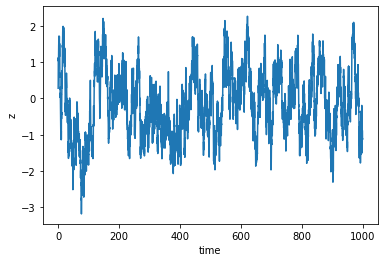

In [3]:
dt=3 # hours
u = ts.exp_autocorr((1000, dt/24), 10, 1, seed=0).compute()
u.plot()

In [4]:
V = skg.Variogram(u.time.values.flatten(), u.values.flatten(), 
                  n_lags=50,
                  model="exponential",
                  maxlag=100,
                 )

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


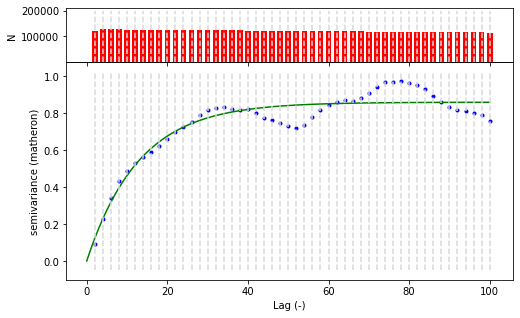

In [5]:
V.plot();

In [6]:
pprint(V.describe())

{'dist_func': 'euclidean',
 'effective_range': 38.834823132789566,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'exponential',
 'normalized_effective_range': 3883.4823132789566,
 'normalized_nugget': 0,
 'normalized_sill': 0.8375395617658039,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': 100,
            'model': 'exponential',
            'n_lags': 50,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 0.8600857986967863}


In [7]:
rmse_exp = V.rmse
print('Exponential RMSE: %.2f' % rmse_exp)

Exponential RMSE: 0.06


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_dd_plot.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


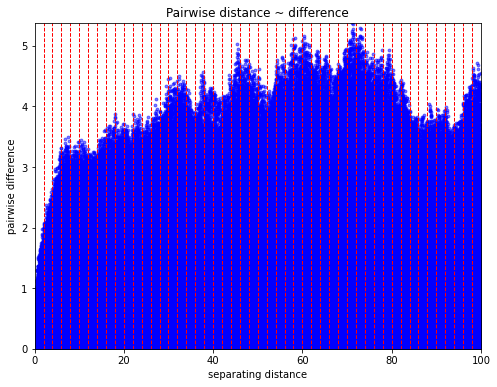

In [9]:
V.distance_difference_plot();

-- model = exponential
  RMSE: 5.88e-02
  range: 38.83


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_11942/2331061135.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


-- model = gaussian
  RMSE: 8.09e-02
  range: 24.27


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_11942/2331061135.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


-- model = matern
  RMSE: 5.86e-02
  range: 38.28


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_11942/2331061135.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


-- model = spherical
  RMSE: 6.89e-02
  range: 29.93


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_11942/2331061135.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


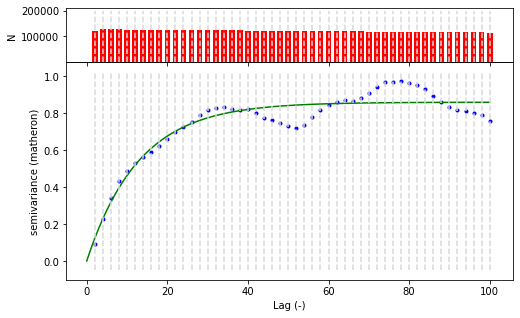

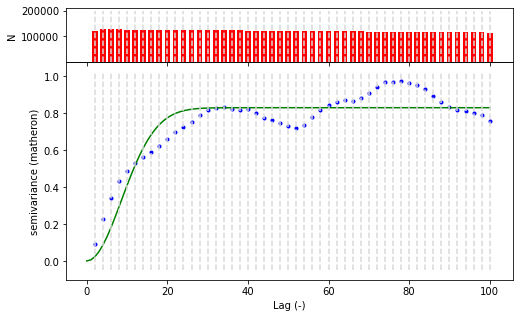

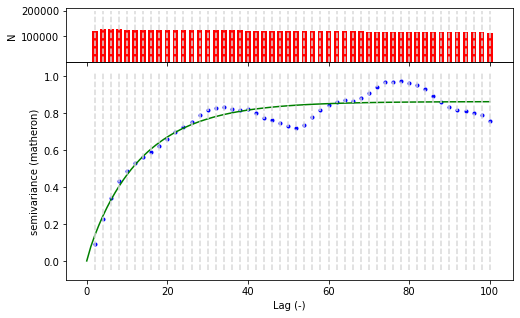

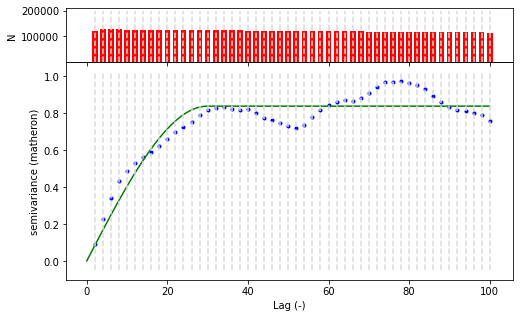

In [15]:
for model in ["exponential", "gaussian", "matern", "spherical"]:
    V.model = model
    rmse = V.rmse
    rg = V.describe().get('effective_range')
    print(f"-- model = {model}")
    print('  RMSE: %.2e' % rmse)
    print('  range: %.2f' % rg)
    fig = V.plot()
    fig.show()

SciKitGStat doc: "The distance at which 95% of the sill are approached is called the effective range"

$
\begin{align}
1 - e^{-t_e/T} = 0.95, \\
T = -t_e / \log(0.05)
\end{align}
$

So for, the corresponding exponential timescale is about a third of the effective distance.

In [13]:
-1/np.log(0.05)

0.33380820069533407

In [5]:
skg.Variogram?

Init signature:
skg.Variogram(
    coordinates=None,
    values=None,
    estimator='matheron',
    model='spherical',
    dist_func='euclidean',
    bin_func='even',
    normalize=False,
    fit_method='trf',
    fit_sigma=None,
    use_nugget=False,
    maxlag=None,
    samples=None,
    n_lags=10,
    verbose=False,
    **kwargs,
)
Docstring:     
Variogram Class

Calculates a variogram of the separating distances in the given
coordinates and relates them to one of the semi-variance measures of
the given dependent values.
Init docstring:
Variogram Class

Parameters
----------
coordinates : numpy.ndarray, MetricSpace
    .. versionchanged:: 0.5.0
        now accepts MetricSpace
    Array of shape (m, n). Will be used as m observation points of
    n-dimensions. This variogram can be calculated on 1 - n
    dimensional coordinates. In case a 1-dimensional array is passed,
    a second array of same length containing only zeros will be
    stacked to the passed one.
    For very large 